# Import

In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(),".."))

import time
import math
import json
import glob

import numpy as np
import pandas as pd
import scipy
from scipy.optimize import minimize
import matplotlib.pyplot as plt

import cv2
import torch
from torch.nn.functional import mse_loss

import pytorch_kinematics as pk
from urdf_parser_py.urdf import URDF

In [2]:
# Explicitly telling to use GPU
torch.set_default_device('cuda')
torch.set_default_dtype(d=torch.float64)

# Helper Functions

In [3]:
def load_json(filename: str):
    # Construct the absolute path by joining the current directory and relative path
    absolute_path = os.path.join(os.getcwd(), '..', filename)
    # Load the JSON data
    with open(absolute_path, 'r') as file:
        json_data = json.load(file)    
    return json_data

def projectPoints(pts_3d, ext_mtx, cam_mtx, dist_coef):
    # Apply extrinsic transformation (rotation + translation)
    pts_3d_transformed = (T_left_ext @ left_chest_pts).reshape(-1,4).T
    
    # Convert back from homogeneous to 2D coordinates
    pts_2d_prime = pts_3d_transformed[:2, :] / pts_3d_transformed[2, :]
    x_prime = pts_2d_prime[0]
    y_prime = pts_2d_prime[1]
    
    # Distortion Parameters Calculation
    k1, k2, p1, p2, k3 = dist_coef
    
    r2 = x_prime**2 + y_prime**2
    r4 = r2**2
    r6 = r2*r4
    a1 = 2*x_prime*y_prime
    a2 = r2 + 2*x_prime**2
    a3 = r2 + 2*y_prime**2
    
    # Radial distortion
    radial_distortion = 1 + k1*r2 + k2*r4 + k3*r6
    
    # Tangential distortion
    tangential_distortion_x = p1*a1 + p2*a2
    tangential_distortion_y = p1*a3 + p2*a1
    
    # Apply distortion
    x_double_prime = x_prime*radial_distortion + tangential_distortion_x
    y_double_prime = y_prime* radial_distortion + tangential_distortion_y
    
    # Intrinsic Camera Matrix
    fx = cam_mtx[0,0]
    cx = cam_mtx[0,2]
    fy = cam_mtx[1,1]
    cy = cam_mtx[1,2]
    
    u = x_double_prime*fx + cx
    v = y_double_prime*fy + cy

    return u,v

def xml_to_str(robot):
    # To XML string with filtering
    temp_str = robot.to_xml_string()
    words = temp_str.split()
    words[5] = '>'
    urdf_str = ' '.join(words)
    return urdf_str

# Initialization

In [4]:
# PyTorch Configs

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float64

In [5]:
# Load Configs
cam_mtxs = load_json('camera_mtx.json')
gaze_ctrs = load_json('calib_params.json')
urdf_path = os.path.join(os.getcwd(),"..","urdf","chest_grace.urdf")
robot = URDF.from_xml_file(urdf_path)

In [6]:
# Load Dataset CSV

data_dir = "final"
csv_file = os.path.join(os.getcwd(),"..","data", data_dir, "240909_grace_dataset.csv")
df = pd.read_csv(csv_file)
temp_df = df.iloc[:,:12]
print('Total:',len(temp_df))
temp_df

Total: 209731


,x_c_l,y_c_l,z_c_l,x_c_r,y_c_r,z_c_r,cmd_theta_lower_neck_pan,cmd_theta_lower_neck_tilt,cmd_theta_upper_neck_tilt,cmd_theta_left_eye_pan,cmd_theta_right_eye_pan,cmd_theta_eyes_tilt
0,-0.873669,-0.334702,0.738088,-1.166921,-0.352033,0.738508,-35,-10,-10,-14,-14,20
1,-0.821681,-0.331576,0.738000,-0.997318,-0.340332,0.738221,-35,-10,-10,-12,-12,20
2,-0.731501,-0.324165,0.738176,-0.868484,-0.332085,0.738360,-35,-10,-10,-10,-10,20
3,-0.672994,-0.320809,0.737795,-0.776648,-0.327031,0.737932,-35,-10,-10,-8,-8,20
4,-0.613507,-0.317492,0.737656,-0.690487,-0.321762,0.737752,-35,-10,-10,-6,-6,20
...,...,...,...,...,...,...,...,...,...,...,...,...
209726,0.792502,-0.267949,0.950136,0.716083,-0.253872,0.953027,35,30,40,4,4,-30
209727,0.871620,-0.284761,0.947121,0.792232,-0.271009,0.950140,35,30,40,6,6,-30
209728,0.958315,-0.302900,0.943909,0.875639,-0.289312,0.947054,35,30,40,8,8,-30
209729,1.054044,-0.323434,0.940457,0.967562,-0.310196,0.943755,35,30,40,10,10,-30


In [7]:
# Convert DF Degrees Column to Radians

data_df = temp_df.copy()
data_df['cmd_theta_lower_neck_pan'] = np.radians(temp_df['cmd_theta_lower_neck_pan'].values)
data_df['cmd_theta_lower_neck_tilt'] = np.radians(temp_df['cmd_theta_lower_neck_tilt'].values)
data_df['cmd_theta_upper_neck_tilt'] = np.radians(temp_df['cmd_theta_upper_neck_tilt'].values)
data_df['cmd_theta_left_eye_pan'] = np.radians(temp_df['cmd_theta_left_eye_pan'].values)
data_df['cmd_theta_right_eye_pan'] = np.radians(temp_df['cmd_theta_right_eye_pan'].values)
data_df['cmd_theta_eyes_tilt'] = np.radians(temp_df['cmd_theta_eyes_tilt'].values)
data_df

,x_c_l,y_c_l,z_c_l,x_c_r,y_c_r,z_c_r,cmd_theta_lower_neck_pan,cmd_theta_lower_neck_tilt,cmd_theta_upper_neck_tilt,cmd_theta_left_eye_pan,cmd_theta_right_eye_pan,cmd_theta_eyes_tilt
0,-0.873669,-0.334702,0.738088,-1.166921,-0.352033,0.738508,-0.610865,-0.174533,-0.174533,-0.244346,-0.244346,0.349066
1,-0.821681,-0.331576,0.738000,-0.997318,-0.340332,0.738221,-0.610865,-0.174533,-0.174533,-0.209440,-0.209440,0.349066
2,-0.731501,-0.324165,0.738176,-0.868484,-0.332085,0.738360,-0.610865,-0.174533,-0.174533,-0.174533,-0.174533,0.349066
3,-0.672994,-0.320809,0.737795,-0.776648,-0.327031,0.737932,-0.610865,-0.174533,-0.174533,-0.139626,-0.139626,0.349066
4,-0.613507,-0.317492,0.737656,-0.690487,-0.321762,0.737752,-0.610865,-0.174533,-0.174533,-0.104720,-0.104720,0.349066
...,...,...,...,...,...,...,...,...,...,...,...,...
209726,0.792502,-0.267949,0.950136,0.716083,-0.253872,0.953027,0.610865,0.523599,0.698132,0.069813,0.069813,-0.523599
209727,0.871620,-0.284761,0.947121,0.792232,-0.271009,0.950140,0.610865,0.523599,0.698132,0.104720,0.104720,-0.523599
209728,0.958315,-0.302900,0.943909,0.875639,-0.289312,0.947054,0.610865,0.523599,0.698132,0.139626,0.139626,-0.523599
209729,1.054044,-0.323434,0.940457,0.967562,-0.310196,0.943755,0.610865,0.523599,0.698132,0.174533,0.174533,-0.523599


In [8]:
# Decision Variables Initial Value

var_dict= {
    'neck_pitch_polyfit_b0': 0.1,
    'neck_pitch_polyfit_b1': 0.1,
    'neck_pitch_polyfit_b2': 0,
    'neck_pitch_polyfit_b3': 0,

    'neck_yaw_polyfit_b0': 0.1,
    'neck_yaw_polyfit_b1': 0.1,
    'neck_yaw_polyfit_b2': 0,
    'neck_yaw_polyfit_b3': 0,

    'head_pitch_polyfit_b0': 0.1,
    'head_pitch_polyfit_b1': 0.1,
    'head_pitch_polyfit_b2': 0,
    'head_pitch_polyfit_b3': 0,

    'eyes_pitch_polyfit_b0': 0.1,
    'eyes_pitch_polyfit_b1': 0.1,
    'eyes_pitch_polyfit_b2': 0,
    'eyes_pitch_polyfit_b3': 0,

    'lefteye_yaw_polyfit_b0': 0.1,
    'lefteye_yaw_polyfit_b1': 0.1,
    'lefteye_yaw_polyfit_b2': 0,
    'lefteye_yaw_polyfit_b3': 0,

    'righteye_yaw_polyfit_b0': 0.1,
    'righteye_yaw_polyfit_b1': 0.1,
    'righteye_yaw_polyfit_b2': 0,
    'righteye_yaw_polyfit_b3': 0,

    'torso_origin_x': 0.12234,
    'torso_origin_y': -0.0325,
    'torso_origin_z': 0.05692,

    'neck_pitch_rot_r': 0,
    
    'head_pitch_origin_z': 0.13172,
    'head_pitch_rot_r': 0,
    'head_pitch_rot_y': 0,

    'eyes_pitch_origin_x': 0.08492,
    'eyes_pitch_origin_z': 0.05186,
    'eyes_pitch_rot_r': 0,
    'eyes_pitch_rot_y': 0,

    'lefteye_yaw_origin_y': 0.02895,
    
    'righteye_yaw_origin_y': -0.02895,

    'lefteye_cam_origin_x': 0.015,
    'lefteye_cam_rot_r': 0,
    'lefteye_cam_rot_p': 0,
    'lefteye_cam_rot_y': 0,

    'righteye_cam_origin_x': 0.015,
    'righteye_cam_rot_r': 0,
    'righteye_cam_rot_p': 0,
    'righteye_cam_rot_y': 0,
}

# Decision Variables 
var_list = list(var_dict.values())

# Variable Names
var_names_list = list(var_dict.keys())

In [9]:
# Index to Name Mapping
var2idx = dict(zip(list(range(len(var_names_list))),var_names_list))
var2idx

{0: 'neck_pitch_polyfit_b0',
 1: 'neck_pitch_polyfit_b1',
 2: 'neck_pitch_polyfit_b2',
 3: 'neck_pitch_polyfit_b3',
 4: 'neck_yaw_polyfit_b0',
 5: 'neck_yaw_polyfit_b1',
 6: 'neck_yaw_polyfit_b2',
 7: 'neck_yaw_polyfit_b3',
 8: 'head_pitch_polyfit_b0',
 9: 'head_pitch_polyfit_b1',
 10: 'head_pitch_polyfit_b2',
 11: 'head_pitch_polyfit_b3',
 12: 'eyes_pitch_polyfit_b0',
 13: 'eyes_pitch_polyfit_b1',
 14: 'eyes_pitch_polyfit_b2',
 15: 'eyes_pitch_polyfit_b3',
 16: 'lefteye_yaw_polyfit_b0',
 17: 'lefteye_yaw_polyfit_b1',
 18: 'lefteye_yaw_polyfit_b2',
 19: 'lefteye_yaw_polyfit_b3',
 20: 'righteye_yaw_polyfit_b0',
 21: 'righteye_yaw_polyfit_b1',
 22: 'righteye_yaw_polyfit_b2',
 23: 'righteye_yaw_polyfit_b3',
 24: 'torso_origin_x',
 25: 'torso_origin_y',
 26: 'torso_origin_z',
 27: 'neck_pitch_rot_r',
 28: 'head_pitch_origin_z',
 29: 'head_pitch_rot_r',
 30: 'head_pitch_rot_y',
 31: 'eyes_pitch_origin_x',
 32: 'eyes_pitch_origin_z',
 33: 'eyes_pitch_rot_r',
 34: 'eyes_pitch_rot_y',
 35: 'le

In [10]:
# Tensor Initialization

# Chest Camera OpenCV to World Orientation (LHR > RHR)
T_opencv_world = torch.Tensor([[0.0, 0.0, 1.0, 0.0],
                               [-1.0, 0.0, 0.0, 0.0],
                               [0.0, -1.0, 0.0, 0.0],
                               [0.0, 0.0, 0.0, 1.0]]).to(dtype=dtype, device=device)

# World Orientation to Chest Camera OpenCV (RHR > LHR)
T_world_opencv = torch.Tensor([[0.0, -1.0, 0.0, 0.0],
                               [0.0, 0.0, -1.0, 0.0],
                               [1.0, 0.0, 0.0, 0.0],
                               [0.0, 0.0, 0.0, 1.0]]).to(dtype=dtype, device=device)

### Camera Projection
# Camera Parameters
left_cam_mtx = torch.Tensor(cam_mtxs['left_eye']['camera_matrix'])
left_dist_coef = torch.Tensor(cam_mtxs['left_eye']['distortion_coefficients']).squeeze()
right_cam_mtx = torch.Tensor(cam_mtxs['right_eye']['camera_matrix'])
right_dist_coef = torch.Tensor(cam_mtxs['right_eye']['distortion_coefficients']).squeeze()

# Camera Projections
x_c_l = torch.Tensor(data_df['x_c_l']).reshape(-1,1).to(dtype=dtype, device=device)
y_c_l = torch.Tensor(data_df['y_c_l']).reshape(-1,1).to(dtype=dtype, device=device)
z_c_l = torch.Tensor(data_df['z_c_l']).reshape(-1,1).to(dtype=dtype, device=device)
x_c_r = torch.Tensor(data_df['x_c_r']).reshape(-1,1).to(dtype=dtype, device=device)
y_c_r = torch.Tensor(data_df['y_c_r']).reshape(-1,1).to(dtype=dtype, device=device)
z_c_r = torch.Tensor(data_df['z_c_r']).reshape(-1,1).to(dtype=dtype, device=device)

# Parallelization GPU

In [11]:
def min_max_scaler(tensor, tensor_min, tensor_max):  
    # Apply Min-Max scaling
    scaled_tensor = (tensor - tensor_min) / (tensor_max - tensor_min)
    
    return scaled_tensor

In [12]:
V = var_list

start = time.time()

### Joint-to-Motor Polynomial Models
x = torch.Tensor(data_df['cmd_theta_lower_neck_tilt']).reshape(-1,1).to(dtype=dtype, device=device)
neck_pitch = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[0]],[V[1]],[V[2]],[V[3]]]).to(dtype=dtype, device=device))

x = torch.Tensor(data_df['cmd_theta_lower_neck_pan']).reshape(-1,1).to(dtype=dtype, device=device)
neck_yaw = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[4]],[V[5]],[V[6]],[V[7]]]).to(dtype=dtype, device=device))

x = torch.Tensor(data_df['cmd_theta_upper_neck_tilt']).reshape(-1,1).to(dtype=dtype, device=device)
head_pitch = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[8]],[V[9]],[V[10]],[V[11]]]).to(dtype=dtype, device=device))

x = torch.Tensor(data_df['cmd_theta_eyes_tilt']).reshape(-1,1).to(dtype=dtype, device=device)
eyes_pitch = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[12]],[V[13]],[V[14]],[V[15]]]).to(dtype=dtype, device=device))

x = torch.Tensor(data_df['cmd_theta_left_eye_pan']).reshape(-1,1).to(dtype=dtype, device=device)
lefteye_yaw = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[16]],[V[17]],[V[18]],[V[19]]]).to(dtype=dtype, device=device))

x = torch.Tensor(data_df['cmd_theta_right_eye_pan']).reshape(-1,1).to(dtype=dtype, device=device)
righteye_yaw = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[20]],[V[21]],[V[22]],[V[23]]]).to(dtype=dtype, device=device))


### URDF
# Variable Assignment
for joint in robot.joints:
    if joint.name == 'torso':
        joint.origin.position[0] = V[24]
        joint.origin.position[1] = V[25]
        joint.origin.position[2] = V[26]
    elif joint.name == 'neck_pitch':
        joint.origin.rotation[0] = V[27]
    elif joint.name == 'head_pitch':
        joint.origin.position[2] = V[28]
        joint.origin.rotation[0] = V[29]
        joint.origin.rotation[2] = V[30]
    elif joint.name == 'eyes_pitch':
        joint.origin.position[0] = V[31]
        joint.origin.position[2] = V[32]
        joint.origin.rotation[0] = V[33]
        joint.origin.rotation[2] = V[34]
    elif joint.name == 'lefteye_yaw':
        joint.origin.position[1] = V[35]
    elif joint.name == 'righteye_yaw':
        joint.origin.position[1] = V[36]
    elif joint.name == 'lefteye_cam':
        joint.origin.position[0] = V[37]
        joint.origin.rotation[0] = V[38]
        joint.origin.rotation[1] = V[39]
        joint.origin.rotation[2] = V[40]
    elif joint.name == 'righteye_cam':
        joint.origin.position[0] = V[41]
        joint.origin.rotation[0] = V[42]
        joint.origin.rotation[1] = V[43]
        joint.origin.rotation[2] = V[44]

# XML to String
urdf_str = xml_to_str(robot)

# Kinematic Chain
chain = pk.build_chain_from_urdf(urdf_str)
chain.to(dtype=dtype, device=device)

# Specifying Joint Angles (radians)
joint_cmd = torch.cat((neck_pitch, neck_yaw, head_pitch, eyes_pitch, lefteye_yaw, righteye_yaw), dim=1)

# Forward Kinematics
ret = chain.forward_kinematics(joint_cmd)



# Realsense to Left Eye Camera (Pytorch) with Points
T_clprime = torch.linalg.inv(ret['realsense'].get_matrix()) @ ret['leftcamera'].get_matrix()

# Realsense to Right Eye Camera (Pytorch) with Points
T_crprime = torch.linalg.inv(ret['realsense'].get_matrix()) @ ret['rightcamera'].get_matrix()

# Extrinsic Matrix
T_left_ext = T_world_opencv @ T_clprime @ T_opencv_world
T_right_ext = T_world_opencv @ T_crprime @ T_opencv_world


# Chest Camera OpenCV Orientation 3D Projection Points
left_chest_pts = torch.cat((x_c_l, y_c_l, z_c_l,torch.ones(x_c_l.shape[0], 1)), dim=1).reshape(-1,4,1)
right_chest_pts = torch.cat((x_c_r, y_c_r, z_c_r,torch.ones(x_c_r.shape[0], 1)), dim=1).reshape(-1,4,1)

# Points Projection
u_left, v_left = projectPoints(left_chest_pts, T_left_ext, left_cam_mtx, left_dist_coef)   
u_right, v_right = projectPoints(right_chest_pts, T_right_ext, right_cam_mtx, right_dist_coef)

# Clamping
u_min_val = 0
u_max_val = 639 
v_min_val = 0
v_max_val = 479
u_left = torch.clamp(u_left, min=u_min_val, max=u_max_val)
v_left = torch.clamp(v_left, min=v_min_val, max=v_max_val)
u_right = torch.clamp(u_right, min=u_min_val, max=u_max_val)
v_right = torch.clamp(v_right, min=v_min_val, max=v_max_val)

# Scaling
u_left = min_max_scaler(u_left, u_min_val, u_max_val)
v_left = min_max_scaler(v_left, v_min_val, v_max_val)
u_right = min_max_scaler(u_right, u_min_val, u_max_val)
v_right = min_max_scaler(v_right, v_min_val, v_max_val)

# True Value
true_u_left = min_max_scaler(gaze_ctrs['left_eye']['x_center'], u_min_val, u_max_val)
true_v_left = min_max_scaler(gaze_ctrs['left_eye']['y_center'], v_min_val, v_max_val)
true_u_right = min_max_scaler(gaze_ctrs['right_eye']['x_center'], u_min_val, u_max_val)
true_v_right = min_max_scaler(gaze_ctrs['right_eye']['y_center'], v_min_val, v_max_val)

# Loss
loss = (torch.sum((u_left-true_u_left)**2 + (v_left-true_v_left)**2 
        + (u_right-true_u_right)**2 + (v_right-true_v_right)**2)/u_left.shape[0])

end = time.time()
print('Elapsed Time: %.f ms' % (1000*(end-start)))
print(loss)
print(u_left.shape, v_left.shape)
print(u_right.shape, v_right.shape)

Elapsed Time: 758 ms
tensor(0.9017, device='cuda:0')
torch.Size([209731]) torch.Size([209731])
torch.Size([209731]) torch.Size([209731])


# Objective Function

In [13]:
def objective_function(V):
    #Joint-to-Motor Polynomial Models
    x = torch.Tensor(data_df['cmd_theta_lower_neck_tilt']).reshape(-1,1).to(dtype=dtype, device=device)
    neck_pitch = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[0]],[V[1]],[V[2]],[V[3]]]).to(dtype=dtype, device=device))
    
    x = torch.Tensor(data_df['cmd_theta_lower_neck_pan']).reshape(-1,1).to(dtype=dtype, device=device)
    neck_yaw = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[4]],[V[5]],[V[6]],[V[7]]]).to(dtype=dtype, device=device))
    
    x = torch.Tensor(data_df['cmd_theta_upper_neck_tilt']).reshape(-1,1).to(dtype=dtype, device=device)
    head_pitch = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[8]],[V[9]],[V[10]],[V[11]]]).to(dtype=dtype, device=device))
    
    x = torch.Tensor(data_df['cmd_theta_eyes_tilt']).reshape(-1,1).to(dtype=dtype, device=device)
    eyes_pitch = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[12]],[V[13]],[V[14]],[V[15]]]).to(dtype=dtype, device=device))
    
    x = torch.Tensor(data_df['cmd_theta_left_eye_pan']).reshape(-1,1).to(dtype=dtype, device=device)
    lefteye_yaw = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[16]],[V[17]],[V[18]],[V[19]]]).to(dtype=dtype, device=device))
    
    x = torch.Tensor(data_df['cmd_theta_right_eye_pan']).reshape(-1,1).to(dtype=dtype, device=device)
    righteye_yaw = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[20]],[V[21]],[V[22]],[V[23]]]).to(dtype=dtype, device=device))
    
    # URDF Variable Assignment
    for joint in robot.joints:
        if joint.name == 'torso':
            joint.origin.position[0] = V[24]
            joint.origin.position[1] = V[25]
            joint.origin.position[2] = V[26]
        elif joint.name == 'neck_pitch':
            joint.origin.rotation[0] = V[27]
        elif joint.name == 'head_pitch':
            joint.origin.position[2] = V[28]
            joint.origin.rotation[0] = V[29]
            joint.origin.rotation[2] = V[30]
        elif joint.name == 'eyes_pitch':
            joint.origin.position[0] = V[31]
            joint.origin.position[2] = V[32]
            joint.origin.rotation[0] = V[33]
            joint.origin.rotation[2] = V[34]
        elif joint.name == 'lefteye_yaw':
            joint.origin.position[1] = V[35]
        elif joint.name == 'righteye_yaw':
            joint.origin.position[1] = V[36]
        elif joint.name == 'lefteye_cam':
            joint.origin.position[0] = V[37]
            joint.origin.rotation[0] = V[38]
            joint.origin.rotation[1] = V[39]
            joint.origin.rotation[2] = V[40]
        elif joint.name == 'righteye_cam':
            joint.origin.position[0] = V[41]
            joint.origin.rotation[0] = V[42]
            joint.origin.rotation[1] = V[43]
            joint.origin.rotation[2] = V[44]
    
    # XML to String
    urdf_str = xml_to_str(robot)
    
    # Kinematic Chain
    chain = pk.build_chain_from_urdf(urdf_str)
    chain.to(dtype=dtype, device=device)
    
    # Specifying Joint Angles (radians)
    joint_cmd = torch.cat((neck_pitch, neck_yaw, head_pitch, eyes_pitch, lefteye_yaw, righteye_yaw), dim=1)
    
    # Forward Kinematics
    ret = chain.forward_kinematics(joint_cmd)
    
    # Realsense to Left Eye Camera (Pytorch) with Points
    T_clprime = torch.linalg.inv(ret['realsense'].get_matrix()) @ ret['leftcamera'].get_matrix()
    
    # Realsense to Right Eye Camera (Pytorch) with Points
    T_crprime = torch.linalg.inv(ret['realsense'].get_matrix()) @ ret['rightcamera'].get_matrix()
    
    # Extrinsic Matrix
    T_left_ext = T_world_opencv @ T_clprime @ T_opencv_world
    T_right_ext = T_world_opencv @ T_crprime @ T_opencv_world
    
    
    # Chest Camera OpenCV Orientation 3D Projection Points
    left_chest_pts = torch.cat((x_c_l, y_c_l, z_c_l,torch.ones(x_c_l.shape[0], 1)), dim=1).reshape(-1,4,1)
    right_chest_pts = torch.cat((x_c_r, y_c_r, z_c_r,torch.ones(x_c_r.shape[0], 1)), dim=1).reshape(-1,4,1)
    
    # Points Projection
    u_left, v_left = projectPoints(left_chest_pts, T_left_ext, left_cam_mtx, left_dist_coef)   
    u_right, v_right = projectPoints(right_chest_pts, T_right_ext, right_cam_mtx, right_dist_coef)

    # Clamping
    u_min_val = 0
    u_max_val = 639 
    v_min_val = 0
    v_max_val = 479
    u_left = torch.clamp(u_left, min=u_min_val, max=u_max_val)
    v_left = torch.clamp(v_left, min=v_min_val, max=v_max_val)
    u_right = torch.clamp(u_right, min=u_min_val, max=u_max_val)
    v_right = torch.clamp(v_right, min=v_min_val, max=v_max_val)
    
    # # Scaling
    u_left = min_max_scaler(u_left, u_min_val, u_max_val)
    v_left = min_max_scaler(v_left, v_min_val, v_max_val)
    u_right = min_max_scaler(u_right, u_min_val, u_max_val)
    v_right = min_max_scaler(v_right, v_min_val, v_max_val)
    
    # True Value
    # true_u_left = gaze_ctrs['left_eye']['x_center']
    # true_v_left = gaze_ctrs['left_eye']['y_center']
    # true_u_right = gaze_ctrs['right_eye']['x_center']
    # true_v_right = gaze_ctrs['right_eye']['y_center']
    true_u_left = min_max_scaler(gaze_ctrs['left_eye']['x_center'], u_min_val, u_max_val)
    true_v_left = min_max_scaler(gaze_ctrs['left_eye']['y_center'], v_min_val, v_max_val)
    true_u_right = min_max_scaler(gaze_ctrs['right_eye']['x_center'], u_min_val, u_max_val)
    true_v_right = min_max_scaler(gaze_ctrs['right_eye']['y_center'], v_min_val, v_max_val)

    
    # Loss
    loss = (torch.sum((u_left-true_u_left)**2 + (v_left-true_v_left)**2 
            + (u_right-true_u_right)**2 + (v_right-true_v_right)**2)/u_left.shape[0])

    # Return Loss
    return loss.item()

In [14]:
objective_function(var_list)

0.9017280608579078

# Optimization

In [15]:
start = time.time()
opt = minimize(objective_function, var_list, method='SLSQP')
end = time.time()
print(opt)
print('Elapsed Time: %.f sec' % (end-start))

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.9017280608579078
       x: [ 1.000e-01  1.000e-01 ...  0.000e+00  0.000e+00]
     nit: 1
     jac: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
    nfev: 46
    njev: 1
Elapsed Time: 30 sec


In [16]:
opt.x

array([ 0.1    ,  0.1    ,  0.     ,  0.     ,  0.1    ,  0.1    ,
        0.     ,  0.     ,  0.1    ,  0.1    ,  0.     ,  0.     ,
        0.1    ,  0.1    ,  0.     ,  0.     ,  0.1    ,  0.1    ,
        0.     ,  0.     ,  0.1    ,  0.1    ,  0.     ,  0.     ,
        0.12234, -0.0325 ,  0.05692,  0.     ,  0.13172,  0.     ,
        0.     ,  0.08492,  0.05186,  0.     ,  0.     ,  0.02895,
       -0.02895,  0.015  ,  0.     ,  0.     ,  0.     ,  0.015  ,
        0.     ,  0.     ,  0.     ])

In [17]:
dict(zip(var_names_list, opt.x))

{'neck_pitch_polyfit_b0': 0.1,
 'neck_pitch_polyfit_b1': 0.1,
 'neck_pitch_polyfit_b2': 0.0,
 'neck_pitch_polyfit_b3': 0.0,
 'neck_yaw_polyfit_b0': 0.1,
 'neck_yaw_polyfit_b1': 0.1,
 'neck_yaw_polyfit_b2': 0.0,
 'neck_yaw_polyfit_b3': 0.0,
 'head_pitch_polyfit_b0': 0.1,
 'head_pitch_polyfit_b1': 0.1,
 'head_pitch_polyfit_b2': 0.0,
 'head_pitch_polyfit_b3': 0.0,
 'eyes_pitch_polyfit_b0': 0.1,
 'eyes_pitch_polyfit_b1': 0.1,
 'eyes_pitch_polyfit_b2': 0.0,
 'eyes_pitch_polyfit_b3': 0.0,
 'lefteye_yaw_polyfit_b0': 0.1,
 'lefteye_yaw_polyfit_b1': 0.1,
 'lefteye_yaw_polyfit_b2': 0.0,
 'lefteye_yaw_polyfit_b3': 0.0,
 'righteye_yaw_polyfit_b0': 0.1,
 'righteye_yaw_polyfit_b1': 0.1,
 'righteye_yaw_polyfit_b2': 0.0,
 'righteye_yaw_polyfit_b3': 0.0,
 'torso_origin_x': 0.12234,
 'torso_origin_y': -0.0325,
 'torso_origin_z': 0.05692,
 'neck_pitch_rot_r': 0.0,
 'head_pitch_origin_z': 0.13172,
 'head_pitch_rot_r': 0.0,
 'head_pitch_rot_y': 0.0,
 'eyes_pitch_origin_x': 0.08492,
 'eyes_pitch_origin_z': 

In [18]:
print(torch.min(u_left), torch.max(u_left))

tensor(0., device='cuda:0') tensor(1., device='cuda:0')


In [19]:
print(torch.min(v_left), torch.max(v_left))

tensor(0., device='cuda:0') tensor(0.3821, device='cuda:0')


In [20]:
print(torch.min(u_right), torch.max(u_right))

tensor(0., device='cuda:0') tensor(1., device='cuda:0')


In [21]:
print(torch.min(v_right), torch.max(v_right))

tensor(0., device='cuda:0') tensor(0.3785, device='cuda:0')


In [22]:
torch.where(u_left == torch.min(u_left))

(tensor([     0,      1,      2,  ..., 204690, 204704, 204839], device='cuda:0'),)

In [23]:
temp_df.iloc[195207,:]

x_c_l                        -0.823294
y_c_l                        -0.688792
z_c_l                         0.791272
x_c_r                        -1.136044
y_c_r                        -0.786120
z_c_r                         0.810761
cmd_theta_lower_neck_pan    -35.000000
cmd_theta_lower_neck_tilt    20.000000
cmd_theta_upper_neck_tilt    40.000000
cmd_theta_left_eye_pan      -14.000000
cmd_theta_right_eye_pan     -14.000000
cmd_theta_eyes_tilt          20.000000
Name: 195207, dtype: float64

<Axes: >

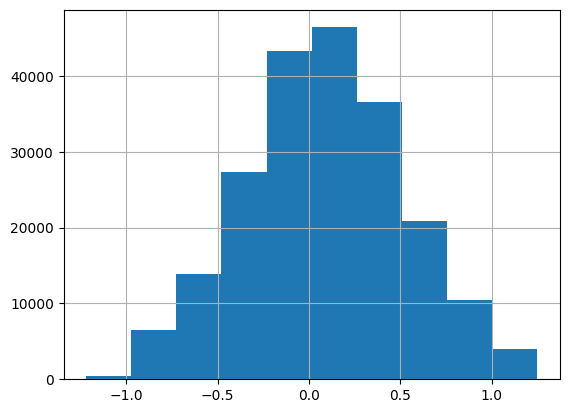

In [24]:
temp_df['x_c_l'].hist()

(array([14163.,  7971., 10395., 13659., 16835., 17816., 16886., 16335.,
        14835., 80836.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

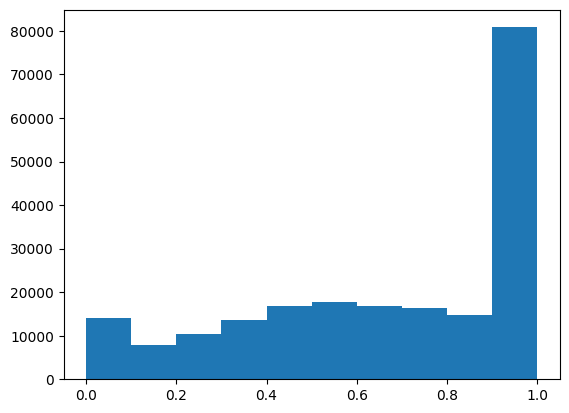

In [25]:
plt.hist(u_left.cpu().numpy())

In [26]:
min_val = -2000
max_val = 2640
filtered_tensor = u_left[(u_left >= min_val) & (u_left <= max_val)]
print(filtered_tensor.shape)

torch.Size([209731])


In [27]:
u_left.shape

torch.Size([209731])